<a href="https://colab.research.google.com/github/erewl/dsp/blob/models-XAI/xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
!pip install shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


In [3]:
!pip install lime

     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=800961a454f9777e668c1424356b6270ee8c62437a35982218bbe2e9c267eca3
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [4]:
!pip install vit-keras

In [5]:
# !pip install wandb

In [6]:
# import libraries
import numpy as np
# random seeds must be set before importing keras & tensorflow
my_seed = 123
np.random.seed(my_seed)
import random 
random.seed(my_seed)
import tensorflow as tf
tf.random.set_seed(my_seed)

from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras.backend as K
import tensorflow as tf
from vit_keras import vit, utils
import tensorflow_addons as tfa
from vit_keras import visualize
import cv2
from google.colab.patches import cv2_imshow

from lime import lime_image

import seaborn as sns


In [ ]:
# import wandb
# from wandb.keras import WandbCallback

# !wandb login

In [7]:
# connect to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [8]:
# define data file paths
ROOT_train = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/train'
ROOT_val = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/val'
ROOT_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test'
knee_data_dir_train = pathlib.Path(ROOT_train)
knee_data_dir_val = pathlib.Path(ROOT_val)
knee_data_dir_test = pathlib.Path(ROOT_test)

In [9]:
# define some hyperparameters
batch_size = 32
img_height = 224
img_width = 224

# if set to True, image data will be augmented during training (rescaling, shear, zoom, flip)
data_augmentation = True

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# load train data 

if not data_augmentation:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_train,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

else:
    train_ds = train_datagen.flow_from_directory(
      knee_data_dir_train,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 5778 images belonging to 5 classes.


In [11]:
# load val data

if not data_augmentation:
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_val,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

else:
    val_ds = train_datagen.flow_from_directory(
      knee_data_dir_val,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 826 images belonging to 5 classes.


In [12]:
# load test data

if not data_augmentation:
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_test,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
else: 
    test_ds = test_datagen.flow_from_directory(
      knee_data_dir_test,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 1656 images belonging to 5 classes.


In [13]:
def show_k_images(k):
  plt.figure(figsize=(10, 10))
  for images, labels in test_ds.take(1):
    for i in range(k):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

### Keras Model Training

In [ ]:
# load DenseNet169

model = tf.keras.applications.DenseNet169(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=5,
)

In [ ]:
# load DenseNet201

model = tf.keras.applications.DenseNet201(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=5,
)

In [ ]:
# ResNet, UNet, ViT

In [ ]:
try:
  from vit_keras import vit, utils
except:
  !pip install vit_keras

In [ ]:
image_size = 224
model = vit.vit_l32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=5
)

1226670080/1226658854 [==============================] - 183s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [ ]:
run = wandb.init(project="dsp", entity="tdebono",
           config={
               "learning_rate":0.0001,
               "epochs":200
           })

config = wandb.config

wandb: Currently logged in as: aml_mordeczki (use `wandb login --relogin` to force relogin)


In [ ]:
# compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate)

model.compile(
  optimizer=optimizer,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
  )

In [ ]:
# define callbacks

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# fit the model

h = model.fit(train_ds, 
              validation_data = val_ds,
              # validation_steps = 826 // batch_size, 
              epochs = config.epochs, verbose = 1, 
              callbacks=[early_stop, WandbCallback()]
              )

Epoch 1/200
181/181 [==============================] - 1812s 9s/step - loss: 1.4488 - accuracy: 0.3840 - val_loss: 1.4586 - val_accuracy: 0.3148
Epoch 2/200
181/181 [==============================] - 214s 1s/step - loss: 1.4136 - accuracy: 0.3962 - val_loss: 2.1019 - val_accuracy: 0.2409
Epoch 3/200
181/181 [==============================] - 214s 1s/step - loss: 1.3502 - accuracy: 0.4238 - val_loss: 1.8549 - val_accuracy: 0.3499
Epoch 4/200
181/181 [==============================] - 214s 1s/step - loss: 1.2498 - accuracy: 0.4637 - val_loss: 1.5665 - val_accuracy: 0.3741
Epoch 5/200
181/181 [==============================] - 216s 1s/step - loss: 1.1719 - accuracy: 0.4974 - val_loss: 1.5962 - val_accuracy: 0.3559
Epoch 6/200
181/181 [==============================] - 216s 1s/step - loss: 1.1058 - accuracy: 0.5260 - val_loss: 1.7034 - val_accuracy: 0.2918
Epoch 7/200
181/181 [==============================] - 216s 1s/step - loss: 1.0464 - accuracy: 0.5564 - val_loss: 2.4920 - val_accuracy

In [ ]:
def plot_performance(h):
  plt.plot(h.history['accuracy'])
  plt.plot(h.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def plot_loss(h):
  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title('training loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

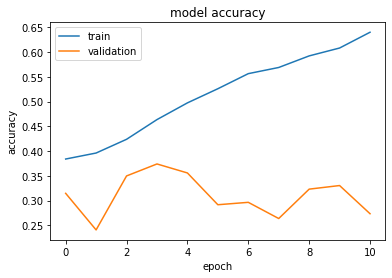

In [ ]:
plot_performance(h)

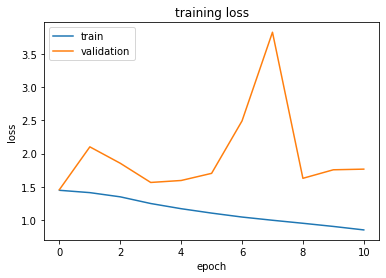

In [ ]:
plot_loss(h)

In [ ]:
score = model.evaluate_generator(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test loss:  1.7239184379577637
Test accuracy:  0.28683575987815857


In [ ]:
wandb.log({'Model': 'DenseNet201',
           'Augmentation': str(data_augmentation),
           'Test loss': score[0],
           'Test accuracy': score[1]})

In [ ]:
# run.join()
wandb.finish()

Test accuracy,▁
Test loss,▁
accuracy,▁▁▂▃▄▅▆▆▇▇█
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,██▇▆▅▄▃▃▂▂▁
val_accuracy,▅▁▇█▇▄▄▂▅▆▃
val_loss,▁▃▂▁▁▂▄█▂▂▂
Augmentation,False
Model,DenseNet201
Test accuracy,0.28684
Test loss,1.72392


### Evaluation Sandbox

In [ ]:
# class_names = test_ds.class_names
# l = []
# yy = []
# for images, labels in test_ds.take(1):
#   for i in range(2):
#     l.append(images[i].numpy())
#     yy.append(class_names[labels[i]])

In [ ]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=-1)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, y_pred)

0.27053140096618356

In [ ]:
class_names = test_ds.class_names

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_gt, y_prob, average="weighted", multi_class="ovr")

0.5059442403177989

In [ ]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_gt, y_pred)

0.0026645405444089

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_gt, y_pred)


0.002906880427811962

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predicted_classes = np.argmax(model.predict(test_ds, steps = test_ds.n // test_ds.batch_size + 1), axis = 1)
true_classes = test_ds.classes
class_labels = list(test_ds.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

In [ ]:
model.save('/content/drive/MyDrive/DSP-H3-Quin/model_4.h5')

### Load Model

In [83]:
image_size = 224
vit_model = vit.vit_b32(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=5
)

353263616/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [84]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(15, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

In [85]:
model.load_weights('/content/drive/MyDrive/DSP-H3-Quin/vitb32_w.h5')

In [86]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 1e-4)

model.compile(
  optimizer=optimizer,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
  )

In [ ]:
# tf.compat.v1.disable_eager_execution()

In [67]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DSP-H3-Quin/model_stuff/model_d169_imgft.h5')

In [68]:
# inference with loaded model
score = model.evaluate_generator(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Test loss:  1.091217279434204
Test accuracy:  0.5899758338928223


### XAI

In [96]:
tip1 = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test/0/9003175L.png'
tip2 = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test/4/9048789L.png'
tip3 = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test/2/9007827R.png'

In [97]:
def load_img(path, bs=True):
  image = cv2.imread(path)
  image = cv2.resize(image, (224, 224))

  return image.reshape(1, 224, 224, 3) if bs else image.reshape(224, 224, 3)

In [98]:
i1 = load_img(tip1, bs=False)
i2 = load_img(tip2, bs=False)
i3 = load_img(tip3, bs=False)

#### Prob Dist Plot

In [112]:
# get model prediction for loaded test image
image = cv2.imread(tip1)
image = cv2.resize(image, (224, 224))
image_re = image.reshape((1, 224, 224, 3))
pred = model.predict(image_re.astype('uint8'))

In [115]:
pred[0]

array([0.11538394, 0.08502655, 0.05041249, 0.46827734, 0.28089967],
      dtype=float32)

In [113]:
pred_unpacked = [np.round(prob, 5) for prob in pred[0]]

Text(0, 0.5, 'KL grades')

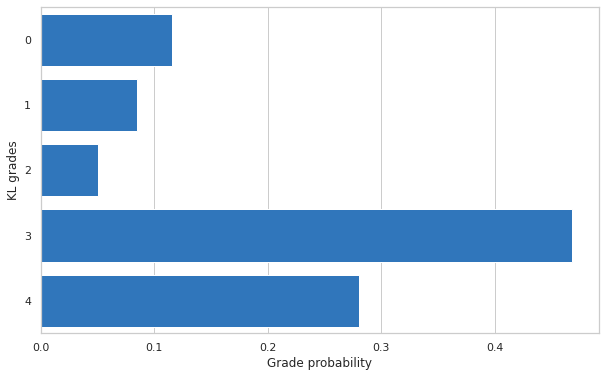

In [114]:
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=pred_unpacked, y=[0, 1, 2, 3, 4], 
            color="#1976d2",
            orient='h')

ax.set_xlabel('Grade probability')
ax.set_ylabel('KL grades')

#### Integrated Gradients

In [29]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [116]:
img_url = {
    '0': tip1,
    '4': tip2,
    '2': tip3
}

img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_url.items()}

In [21]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

In [22]:
baseline = tf.zeros(shape=(224,224,3))

In [23]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [24]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [34]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['4'],
    alphas=alphas)

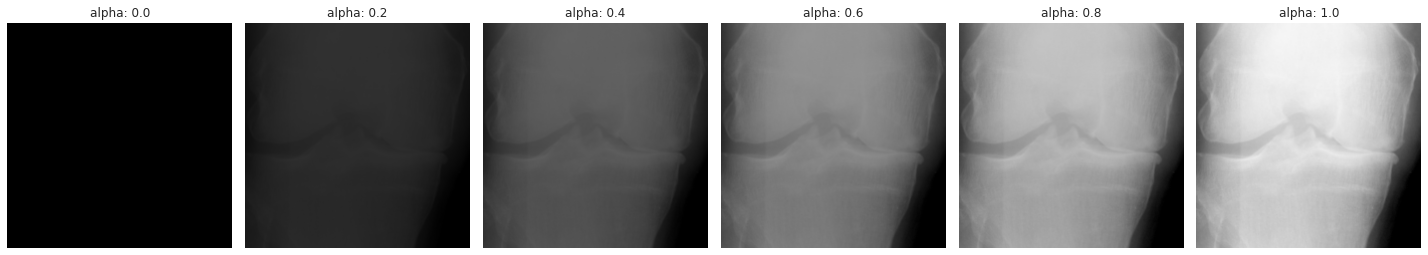

In [35]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [36]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [ ]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=4)

In [47]:
print(path_gradients.shape)

(51, 224, 224, 3)


In [48]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [49]:
ig = integral_approximation(
    gradients=path_gradients)

In [42]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Stack path gradients together row-wise into single tensor.
  total_gradients = tf.stack(gradient_batch)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [121]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [51]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['4'],
                                       target_class_idx=4,
                                       m_steps=240)

In [53]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

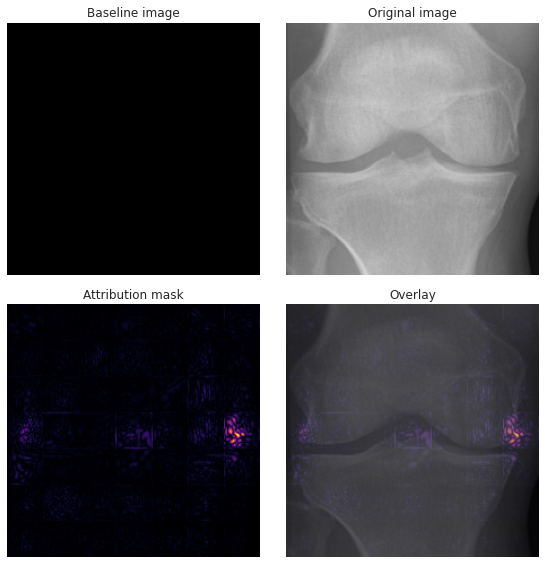

In [122]:
_ = plot_img_attributions(image=img_name_tensors['2'],
                          baseline=baseline,
                          target_class_idx=2,
                          m_steps=200,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

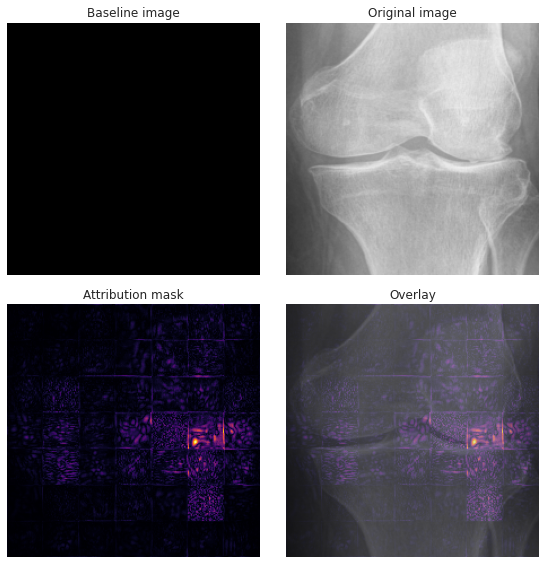

In [123]:
_ = plot_img_attributions(image=img_name_tensors['4'],
                          baseline=baseline,
                          target_class_idx=4,
                          m_steps=200,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

#### Shap

In [ ]:
import shap

class_names = [0, 1, 2, 3, 4]
cns_array = np.asarray(class_names)

def preprocess_input_(i):
  return i.reshape((1, 224, 224, 3))

def f_(x):
  x_ = x.copy()
  x_ = preprocess_input_(x_)
  return model.predict(x_.astype('uint8'))

masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))

explainer = shap.Explainer(f_, masker, output_names=cns_array)
# explainer = shap.Explainer(model, masker, output_names=cns_array)


shap_values = explainer(i1, max_evals=100, batch_size=32, outputs=shap.Explanation.argsort.flip[:1])

# shap.image_plot(shap_values)

In [ ]:
shap.image_plot(shap_values, labels=class_names)

AssertionError: ignored

#### ViT Attention Map

In [ ]:
vm = model.layers[0]

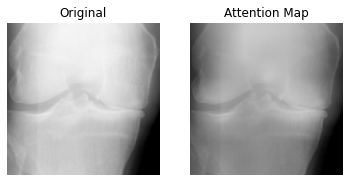

In [ ]:
image = cv2.imread(test_image_path)
image = cv2.resize(image, (224, 224))

attention_map = visualize.attention_map(model = vm, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [ ]:
grayimg = cv2.cvtColor(attention_map, cv2.COLOR_BGR2GRAY)

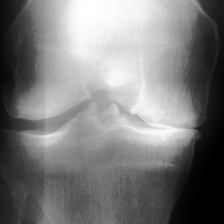

In [ ]:
image_enhanced = cv2.equalizeHist(grayimg)
cv2_imshow(image_enhanced)

#### LIME

In [ ]:
image = cv2.imread(test_image_path)
image = image.reshape((224, 224, 3))

In [ ]:
def plot_image(img):
  plt.imshow(img.astype("uint8"))

In [ ]:
# instantiate LIME explainer
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(image.astype('uint8'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(f"Top predicted labels: {explanation.top_labels}")

Top predicted labels: [4, 3, 0]


(-0.5, 223.5, 223.5, -0.5)

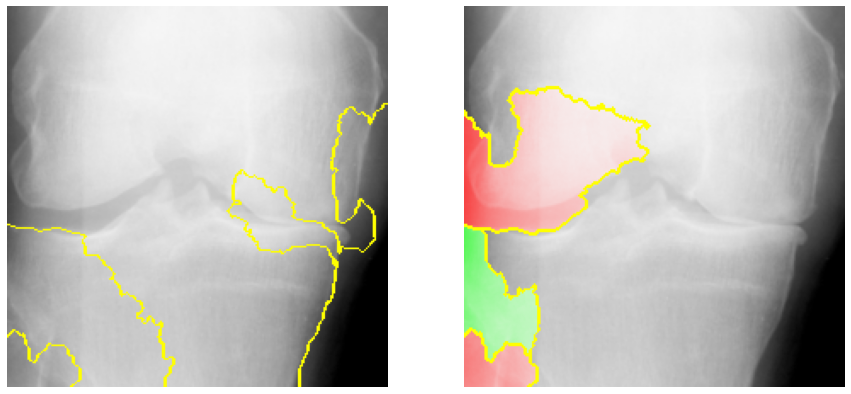

In [ ]:
# plot image with LIME mask

from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

### GradCam

#### GradCam.py

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx=None, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

#### GradCam Impl

In [ ]:
image = cv2.imread(test_image_path)
image = cv2.resize(image, (224, 224))
image2 = image.copy()
image_re = image.reshape((1, 224, 224, 3))
image_re2 = image_re.copy()

In [ ]:
# compute heatmap
# conv5_block32_concat
# Transformer/encoderblock_11
# embedding

icam = GradCAM(model, layerName='conv5_block32_concat') 
heatmap = icam.compute_heatmap(image_re)
heatmap = cv2.resize(heatmap, (224, 224))

In [ ]:
print(heatmap.shape, image.shape, image_re.shape)

(224, 224) (224, 224, 3) (1, 224, 224, 3)


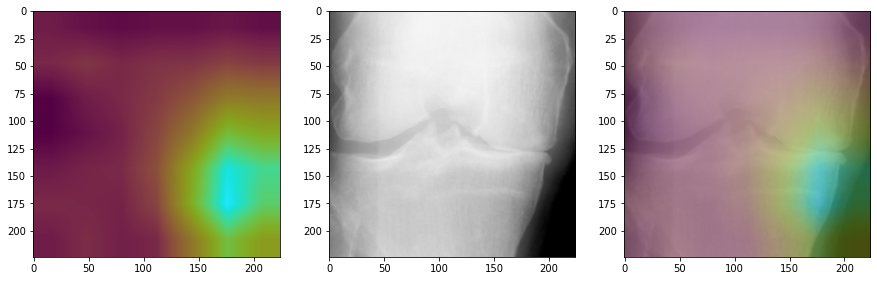

In [ ]:
# overlay heatmap onto test image

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

In [ ]:
heatmap2 = icam.compute_heatmap(image_re)
heatmap2 = cv2.resize(heatmap, (224, 224))

In [ ]:
image2 = cv2.imread(test_image_path)
image2 = cv2.resize(image, (224, 224))

In [ ]:
def draw_bounding_box(heatmap, image, show_heatmap=False):

  gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 100, 100, 0)[1]

  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      w *= 0.9
      h *= 0.65

      w, h = int(w), int(h)

      rect = cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

  if show_heatmap:
    cv2_imshow(heatmap)
    cv2_imshow(image)
  else:
    cv2_imshow(image)
  
  return {'top_left': (x, y),
          'bottom_right': (x + w, y + h)}

def draw_arrows(heatmap, image, only_one=False):

  gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 100, 100, 0)[1]

  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      w *= 0.9
      h *= 0.65

      w, h = int(w), int(h)

      color = (252, 3, 3)
      thickness = 2

      if not only_one:
        # top left
        start_point = (x, y)
        end_point = (x + int(0.25 * w), y + int(0.25 * h))
        image = cv2.arrowedLine(image, start_point, end_point,
                                        color, thickness)
        # bottom right
        start_point2 = (x + w, y + h)
        end_point2 = (x + int(0.75 * w), y + int(0.75 * h))
        image = cv2.arrowedLine(image, start_point2, end_point2,
                                        color, thickness)
        # bottom left
        start_point3 = (x, y + h)
        end_point3 = (x + int(0.25 * w), y + int(0.75 * h) )
        image = cv2.arrowedLine(image, start_point3, end_point3,
                                        color, thickness)
        # top right
        start_point4 = (x + w, y)
        end_point4 = (x + int(0.75 * w), y + int(0.25 * h) )
        image = cv2.arrowedLine(image, start_point4, end_point4,
                                        color, thickness)
        
        
        return {'top_left': (start_point, end_point),
                'bottom_right': (start_point2, end_point2),
                'bottom_left': (start_point3, end_point3),
                'top_right': (start_point4, end_point4)}
            
      else:
        start_point = (x, y)
        end_point = (x + int(0.25 * w), y + int(0.25 * h))
        image = cv2.arrowedLine(image, start_point, end_point,
                                        color, thickness)
        
        return {'top_left': (start_point, end_point)}


# draws arrows ('a') or bounding box ('bb') on white background
def draw_on_blank_canvas(heatmap, type='bb', to_transparent=False):
  assert (type == 'bb' or type == 'a')

  # not 100% sure if working properly
  if to_transparent:
    # blank_img = np.zeros([224,224,4],dtype=np.uint8)
    # blank_img.fill(255)
    # blank_img[np.where(np.all(blank_img[..., :3] == 255, -1))] = 0
    blank_img = np.zeros((224, 224, 4), dtype=np.uint8)
  else:
    blank_img = np.zeros([224,224,3],dtype=np.uint8)
    blank_img.fill(255)

  if type == 'bb':
    coords_bb = draw_bounding_box(heatmap=heatmap, image=blank_img, show_heatmap=False)
  if type == 'a':
    coords_a = draw_arrows(heatmap=heatmap, image=blank_img, show_heatmap=False)


In [ ]:
c = draw_on_blank_canvas(heatmap2, type='a', to_transparent=False)

In [ ]:
coords_box = draw_bounding_box(heatmap2, image2)

In [ ]:
coords_arrows = draw_arrows(heatmap2, image2)

In [ ]:
# calculate corner points

# gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
# gray = np.float32(gray)

# dst = cv2.cornerHarris(gray,2,3,0.04)
# dst = cv2.dilate(dst,None)

# image2[dst>0.01*dst.max()]=[0,0,255]

# cv2_imshow(image2)

#### Score-CAM

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'], run_eagerly=False)

In [ ]:
model.run_eagerly = True

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import gc

def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array, ))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  

    return cam

def GradCamPlusPlus(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0  

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

import tensorflow.keras

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications.vgg16 import preprocess_input

def build_guided_model(build_model_function):
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model_function()
    return new_model

def GuidedBackPropagation(model, img_array, layer_name):
    model_input = model.input
    layer_output = model.get_layer(layer_name).output
    max_output = K.max(layer_output, axis=3)
    grads = tf.gradients(max_output, model_input)[0]
    get_output = K.function([model_input], [grads])
    saliency = get_output([img_array])
    saliency = np.clip(saliency[0][0], 0.0, 1.0)  # scale 0 to 1.0  
    return saliency

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asa

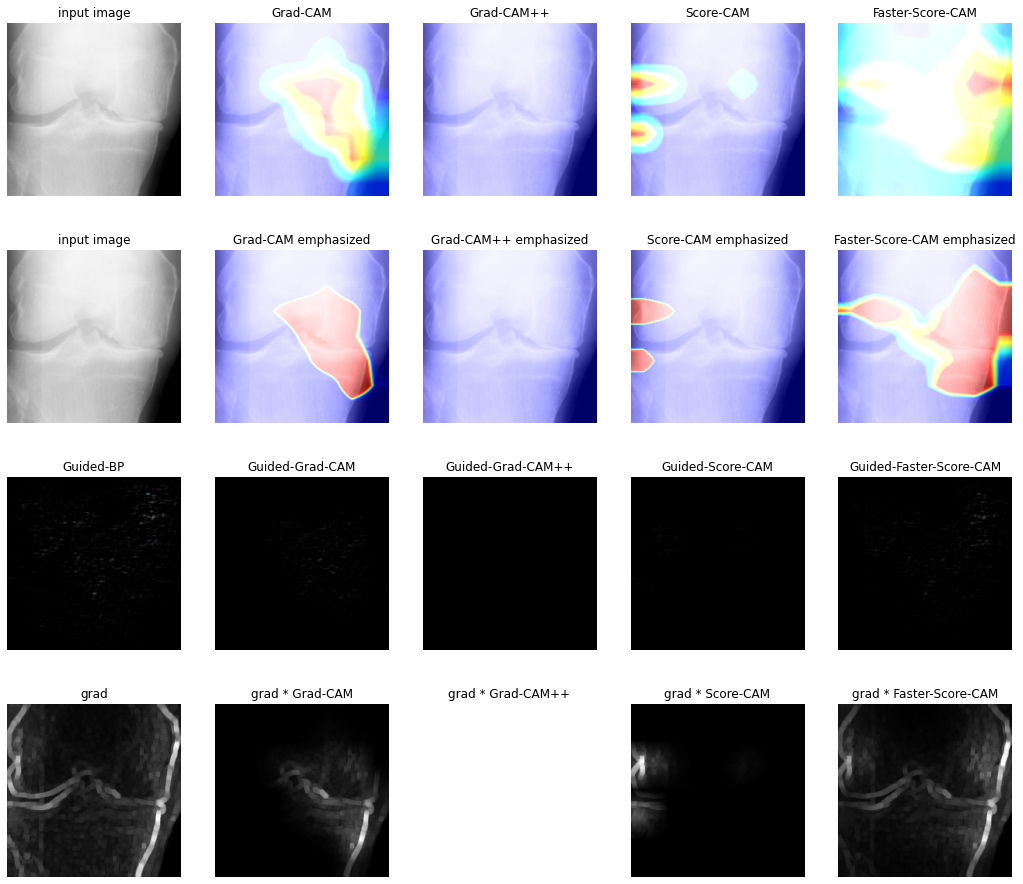

In [ ]:
img_path = test_image_path
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

layer_name = "conv5_block32_concat"

grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

saliency = GuidedBackPropagation(model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

faster_score_cam_resized = cv2.resize(faster_score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  #Get image gradient
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  #Fattening process
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized
grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 16))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
ax[0,3].imshow(score_cam_superimposed)
ax[0,3].set_title("Score-CAM")
ax[0,4].imshow(faster_score_cam_superimposed)
ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
ax[1,3].imshow(score_cam_emphasized)
ax[1,3].set_title("Score-CAM emphasized")
ax[1,4].imshow(faster_score_cam_emphasized)
ax[1,4].set_title("Faster-Score-CAM emphasized")
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
ax[2,3].imshow(guided_score_cam)
ax[2,3].set_title("Guided-Score-CAM")
ax[2,4].imshow(guided_faster_score_cam)
ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
ax[3,3].imshow(grad_times_score_cam, 'gray')
ax[3,3].set_title("grad * Score-CAM")
ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
ax[3,4].set_title("grad * Faster-Score-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()

### PyTorch Pre-trained Model (ignore this part for now)

In [ ]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
ROOT_train = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/train'
ROOT_val = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/val'
ROOT_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test'
ROOT_auto_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test'

In [ ]:
ROOT = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224'

In [ ]:
TEST = 'test'
TRAIN = 'train'
VAL ='val'
EPOCHS = 30

In [ ]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(ROOT, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True), 
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

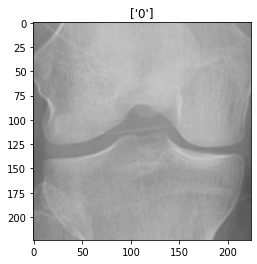

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders[TEST]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/DSP-H3-Quin/model_stuff/vgg16/vgg-16-SGD-1/6-0.662-0.685-0.441.pth'

In [ ]:
model = torch.load(MODEL_PATH)
if torch.cuda.is_available():
    model.cuda()

In [ ]:
# model = models.vgg16()
# model.load_state_dict(copy.deepcopy(torch.load(MODEL_PATH)))

In [ ]:
for param in model.features.parameters():
    param.required_grad = False

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
model.classifier = nn.Sequential(*features) 
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)


Epoch: 1/30


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


AttributeError: ignored

In [ ]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [ ]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

AttributeError: ignored

In [ ]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))